# Understanding the positional encoding

_This notebook is brought to you by [Vladislav Goncharenko](https://www.linkedin.com/in/vladislav-goncharenko/)_ ([girafe-ai](https://github.com/girafe-ai)).

In [1]:
# If using Colab, uncomment this cell
!pip install -Uq plotly

     |████████████████████████████████| 13.2MB 300kB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [3]:
plt.rcParams.update({"font.size": 14})

Positional Encoding matrix components proposed in the article

$$
PE_{(pos,2i)} = 
\sin \left( \frac{pos}{10000^{2i/d_{\text{model}}}} \right) \sim
$$

$$
\sim \sin \left( \exp \left( -\frac{2i}{d_{\text{model}}} \right) \cdot \text{pos} \right) =
\sin(\omega \cdot t)
$$

$$ \\ $$

$$
PE_{(pos,2i+1)} =
\cos(\dots) \sim \cos (\omega \cdot t)
$$

Let's treat $\text{pos}$ as time and number of embedding component as carrier frequency of our signal.

Note that carrier frequencies decrease exponentionally.

In [4]:
def make_carriers(d_mod, denom):
    return 1 / np.power(denom, np.arange(d_mod) / d_mod)

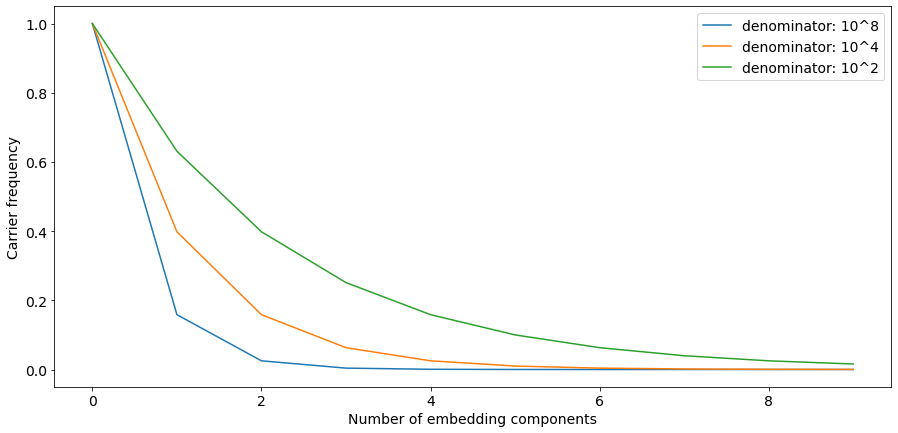

In [5]:
carriers = {i: make_carriers(10, 10 ** i) for i in (8, 4, 2)}

plt.figure(figsize=(15, 7))
for i, carrier in carriers.items():
    plt.plot(carrier, label=f"denominator: 10^{i}")
plt.legend()
plt.xlabel("Number of embedding components")
plt.ylabel("Carrier frequency")
plt.show()

In fact, different frequencies correspond to different "clocks" that we have to measure $\text{pos}$ as time.

Model doesn't know $\text{pos}$ value directly but it sees all the "times" (in fact phases) of different "clocks" ($\sin$s and $\cos$s of different frequencies).

By having representative suits of "clocks" we can definetly say _what time is it now ($\text{pos}$ value)_ for every given "moment".

In [6]:
def make_pa_matrix(n_pos, d_mod, denom):
    res = np.empty((n_pos, d_mod))
    carriers = make_carriers(d_mod, denom)

    for pos in range(n_pos):
        if pos % 2:
            funct = np.sin
        else:
            funct = np.cos

        for i in range(d_mod):
            res[pos, i] = funct((pos // 2) * carriers[i])
    return res

## 2D case

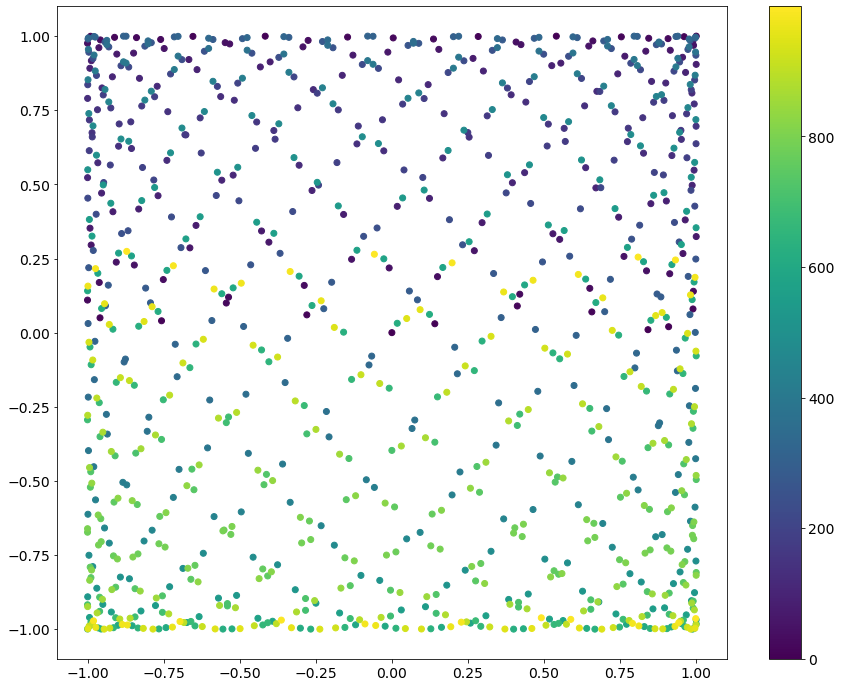

In [7]:
pa2 = make_pa_matrix(1000, 2, 10 ** 4)

plt.figure(figsize=(15, 12))
plt.scatter(pa2[:, 0], pa2[:, 1], c=np.arange(len(pa2)))
plt.colorbar()
plt.show()

**Nice and harmonic picture, isn't it?**

That's because the curve plotted is [Lissajou's curve](https://en.wikipedia.org/wiki/Lissajous_curve):

![](https://upload.wikimedia.org/wikipedia/commons/5/5d/Lissajous_animation.gif)

Curve implicitly specified by harmonic coordinates

$$\left\{ \begin{align}
  & x(t)=A\sin (at+\delta ) \\ 
 & y(t)=B\sin (bt) \\ 
\end{align} \right.
$$

In our case $\delta = \pi / 2$.

## 3D case

In [8]:
pa3 = make_pa_matrix(250, 3, 2 ** 3)

In [9]:
pa3_df = pd.DataFrame(
    np.concatenate((pa3, np.arange(len(pa3))[:, None]), axis=1),
    columns=["x", "y", "z", "c"],
)
pa3_df.head()

x         y         z    c
0  1.000000  1.000000  1.000000  0.0
1  0.000000  0.000000  0.000000  1.0
2  0.540302  0.877583  0.968912  2.0
3  0.841471  0.479426  0.247404  3.0
4 -0.416147  0.540302  0.877583  4.0

In [10]:
fig = px.scatter_3d(pa3_df, x="x", y="y", z="z", color="c")
fig.show()